In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
raw_dataset = pd.read_csv("bd_aribnb.csv",
                      na_values = "?", comment='\t',
                      sep=",")

dataset = raw_dataset.copy()
dataset.tail()

accommodates  bedrooms  bathrooms  beds    price  minimum_nights  \
10489             2       1.0        1.0   1.0   $75.00               1   
10490             4       2.0        1.0   2.0  $100.00               1   
10491             4       2.0        1.0   2.0  $130.00               4   
10492             2       1.0        1.0   1.0   $60.00               1   
10493             2       1.0        1.0   1.0   $25.00               6   

       maximum_nights  number_of_reviews  
10489            1125                  0  
10490            1125                  0  
10491            1125                  0  
10492               2                  0  
10493            1125                  0

In [5]:
dataset.isna().sum()

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64

In [9]:
dataset = dataset.dropna()

In [7]:
dataset['price'] = dataset['price'].str.replace('$','')
dataset.tail()

accommodates  bedrooms  bathrooms  beds   price  minimum_nights  \
10489             2       1.0        1.0   1.0   75.00               1   
10490             4       2.0        1.0   2.0  100.00               1   
10491             4       2.0        1.0   2.0  130.00               4   
10492             2       1.0        1.0   1.0   60.00               1   
10493             2       1.0        1.0   1.0   25.00               6   

       maximum_nights  number_of_reviews  
10489            1125                  0  
10490            1125                  0  
10491            1125                  0  
10492               2                  0  
10493            1125                  0

In [8]:
dataset['price'] = pd.to_numeric(dataset['price'],errors='coerce')
dataset.tail()

accommodates  bedrooms  bathrooms  beds  price  minimum_nights  \
10489             2       1.0        1.0   1.0   75.0               1   
10490             4       2.0        1.0   2.0  100.0               1   
10491             4       2.0        1.0   2.0  130.0               4   
10492             2       1.0        1.0   1.0   60.0               1   
10493             2       1.0        1.0   1.0   25.0               6   

       maximum_nights  number_of_reviews  
10489            1125                  0  
10490            1125                  0  
10491            1125                  0  
10492               2                  0  
10493            1125                  0

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

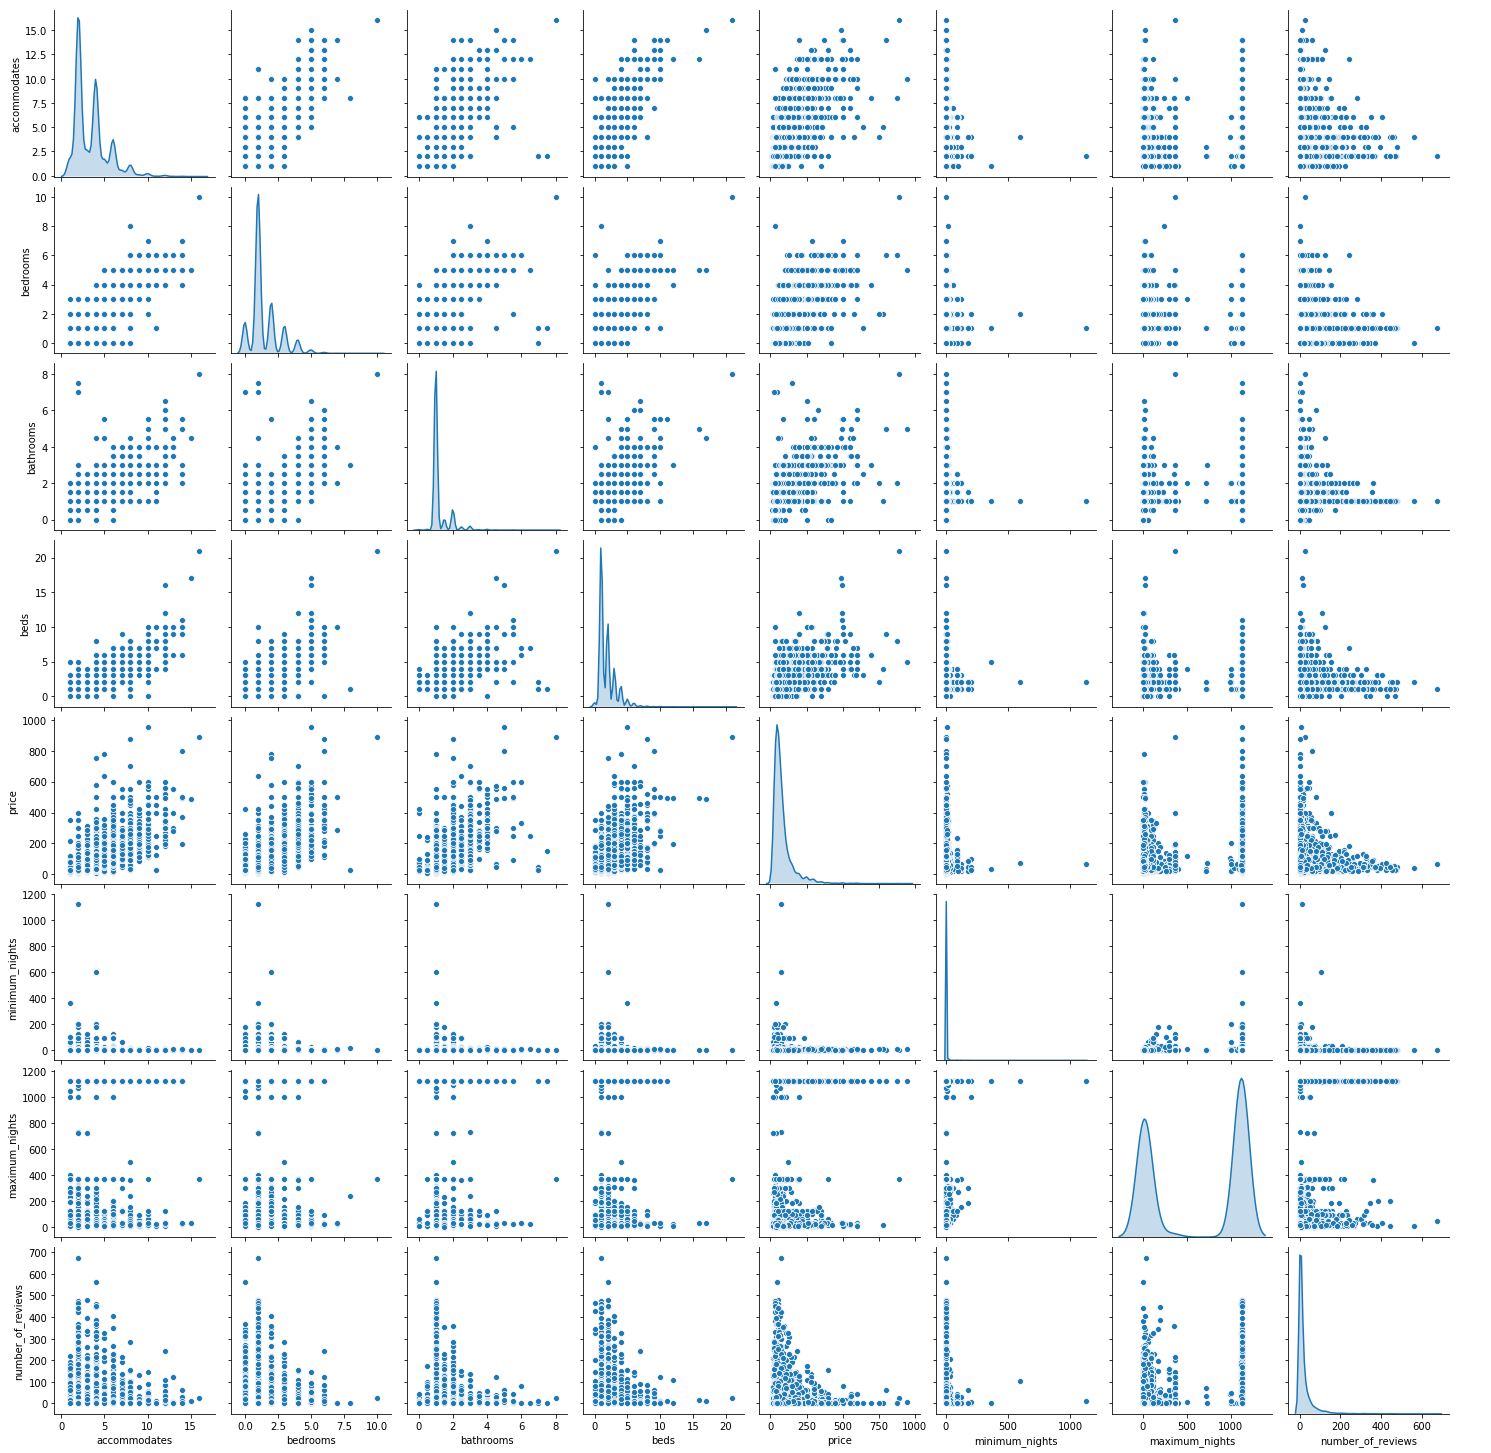

In [11]:
sns.pairplot(train_dataset[["accommodates", "bedrooms", "bathrooms", "beds","price","minimum_nights","maximum_nights","number_of_reviews"]], 
             diag_kind="kde")

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

count        mean         std  min   25%     50%     75%  \
accommodates       8387.0    3.458567    1.930041  1.0   2.0     3.0     4.0   
bedrooms           8387.0    1.468344    1.078725  0.0   1.0     1.0     2.0   
bathrooms          8387.0    1.212710    0.536140  0.0   1.0     1.0     1.0   
beds               8387.0    1.891141    1.299967  0.0   1.0     1.0     2.0   
minimum_nights     8387.0    4.016454   17.945514  1.0   1.0     2.0     3.0   
maximum_nights     8387.0  640.266484  543.260886  1.0  20.0  1125.0  1125.0   
number_of_reviews  8387.0   21.240730   43.189333  0.0   1.0     7.0    21.0   

                      max  
accommodates         16.0  
bedrooms             10.0  
bathrooms             8.0  
beds                 21.0  
minimum_nights     1125.0  
maximum_nights     1125.0  
number_of_reviews   675.0

In [13]:
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 52.30843 ],
       [ 94.68245 ],
       [ 40.09222 ],
       [106.57122 ],
       [ 65.80184 ],
       [ 89.009705],
       [ 74.10432 ],
       [ 62.60939 ],
       [ 76.1552  ],
       [109.94016 ]], dtype=float32)

In [18]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [88]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss        mae          mse     val_loss    val_mae      val_mse  \
995  1744.743113  26.316797  1744.743530  2476.991689  29.088268  2476.991455   
996  1750.696119  26.314123  1750.697021  2416.814482  29.043846  2416.814697   
997  1748.389187  26.318140  1748.389771  2533.185860  29.853294  2533.185547   
998  1763.343034  26.326757  1763.343018  2430.605322  29.173508  2430.605469   
999  1756.737412  26.296177  1756.737427  2506.241127  30.795746  2506.240967   

     epoch  
995    995  
996    996  
997    997  
998    998  
999    999

In [95]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([20,40])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1500,3000])
  plt.legend()
  plt.show()


plot_history(history)

In [96]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} price".format(mae))

2097/2097 - 0s - loss: 2578.0568 - mae: 30.7215 - mse: 2578.0566
Testing set Mean Abs Error: 30.72 price


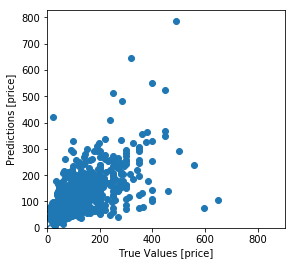

In [97]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

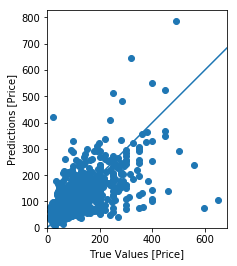

In [104]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')

plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
# lims = [0, 1000]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot([-100, 100], [-100, 100])
_ = plt.plot(lims, lims)


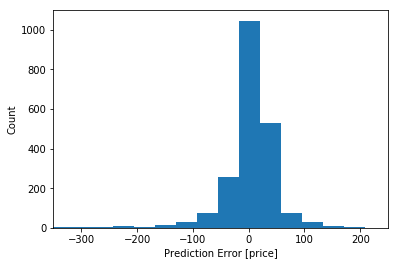

In [110]:
error = test_predictions - test_labels
plt.xlim(-350,250)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [price]")
_ = plt.ylabel("Count")